<a href="https://colab.research.google.com/github/Holmes-Alan/ATM_demo/blob/main/ATM_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PCA analysis for CO2 emission**

download the data from https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles/data

Data shape: (7385, 12)
    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6 

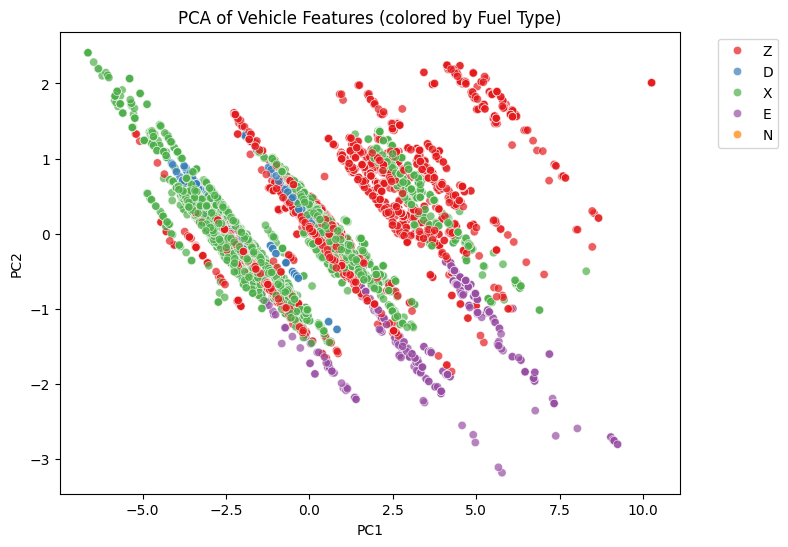


Feature contributions to PCs:
                                       PC1       PC2       PC3
Engine Size(L)                    0.362850  0.535007  0.114023
Cylinders                         0.352098  0.633758  0.029745
Fuel Consumption City (L/100 km)  0.393758 -0.183362  0.188258
Fuel Consumption Hwy (L/100 km)   0.379133 -0.351825  0.482900
Fuel Consumption Comb (L/100 km)  0.393367 -0.244008  0.291617
Fuel Consumption Comb (mpg)      -0.375948  0.308504  0.635548
CO2 Emissions(g/km)               0.386659  0.000733 -0.478037


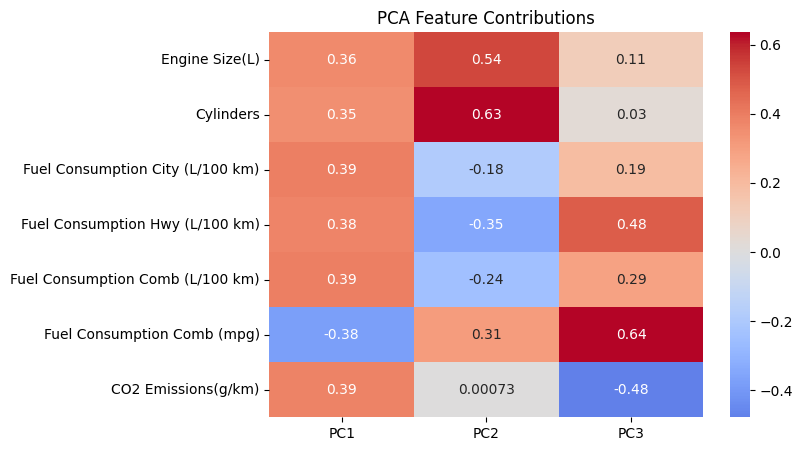

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# 1. Load dataset (assuming uploaded to Colab)
# Example: from google.colab import files; files.upload()
df = pd.read_csv("CO2 Emissions_Canada.csv")
print("Data shape:", df.shape)
print(df.head())

# 2. Select numerical features for PCA
num_features = [
    'Engine Size(L)',
    'Cylinders',
    'Fuel Consumption City (L/100 km)',
    'Fuel Consumption Hwy (L/100 km)',
    'Fuel Consumption Comb (L/100 km)',
    'Fuel Consumption Comb (mpg)',
    'CO2 Emissions(g/km)'
]
X = df[num_features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA (3 components for 3D visualization)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# 4. 2D Visualization: scatter plot of first 2 PCs
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=df.loc[X.index, 'Fuel Type'],
    palette="Set1", alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Vehicle Features (colored by Fuel Type)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# 5. 3D Visualization with Plotly
fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    color=df.loc[X.index, 'Fuel Type'],
    hover_name=df.loc[X.index, 'Make'],
    title="3D PCA of Vehicle Features (colored by Fuel Type)",
    labels={"x":"PC1","y":"PC2","z":"PC3"}
)
fig.show()

# 6. Feature contribution (loadings)
loadings = pd.DataFrame(pca.components_.T,
                        columns=["PC1","PC2","PC3"],
                        index=num_features)
print("\nFeature contributions to PCs:")
print(loadings)

# Plot loadings as heatmap
plt.figure(figsize=(7,5))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Feature Contributions")
plt.show()


**Neural Network for dimension reduction**

a simple AutoEncoder structure

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Load CO2 Emissions Canada dataset
df = pd.read_csv("CO2 Emissions_Canada.csv")

# Select numerical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[num_features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

# Define a simple autoencoder for 2D latent space
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

input_dim = X_scaled.shape[1]
latent_dim = 2  # 2D for interactive visualization
ae = Autoencoder(input_dim, latent_dim)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)
num_epochs = 500

for epoch in range(num_epochs):
    optimizer.zero_grad()
    x_recon, z = ae(X_scaled)
    loss = criterion(x_recon, X_scaled)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Get latent representations
with torch.no_grad():
    _, latent_vectors = ae(X_scaled)
latent_vectors = latent_vectors.numpy()

# Interactive 2D scatter plot using Plotly
fig = px.scatter(
    x=latent_vectors[:,0], y=latent_vectors[:,1],
    color=df.loc[X.index, 'CO2 Emissions(g/km)'],
    hover_data={col: df.loc[X.index, col] for col in X.columns},
    labels={'x': 'Latent Dim 1', 'y': 'Latent Dim 2', 'color': 'CO2 Emissions'},
    title='2D Latent Space from Autoencoder (Interactive)'
)
fig.show()

Epoch 100/500, Loss: 0.0228
Epoch 200/500, Loss: 0.0174
Epoch 300/500, Loss: 0.0146
Epoch 400/500, Loss: 0.0132
Epoch 500/500, Loss: 0.0122


**Linear regression for CO2 emission prediction**

Mean Squared Error: 338.02
R^2 Score: 0.90


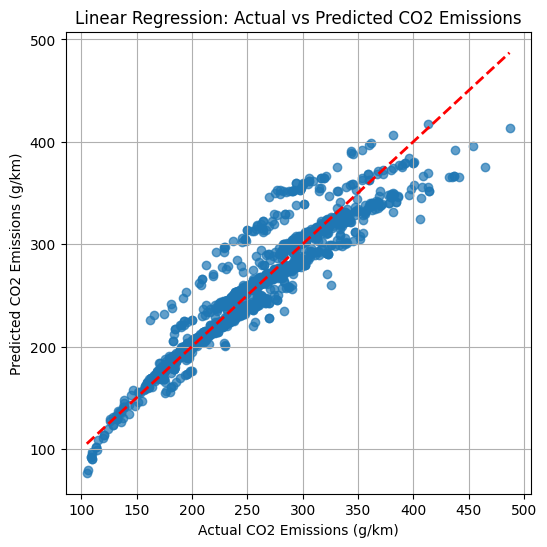

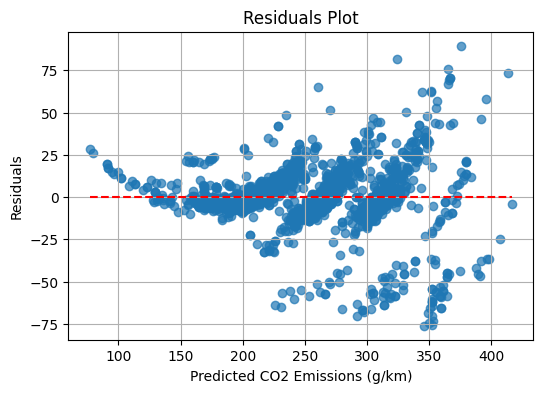

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load CO2 Emissions Canada dataset
df = pd.read_csv("CO2 Emissions_Canada.csv")

# Select numerical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[num_features].dropna()

# Separate features and target (CO2 Emissions)
y = X['CO2 Emissions(g/km)']
X = X.drop(columns=['CO2 Emissions(g/km)'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Visualization: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions (g/km)')
plt.ylabel('Predicted CO2 Emissions (g/km)')
plt.title('Linear Regression: Actual vs Predicted CO2 Emissions')
plt.grid(True)
plt.show()

# Visualization: residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted CO2 Emissions (g/km)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

Epoch 100/500, Loss: 506.06
Epoch 200/500, Loss: 322.44
Epoch 300/500, Loss: 308.06
Epoch 400/500, Loss: 302.64
Epoch 500/500, Loss: 300.06
Mean Squared Error: 222.66
R^2 Score: 0.94


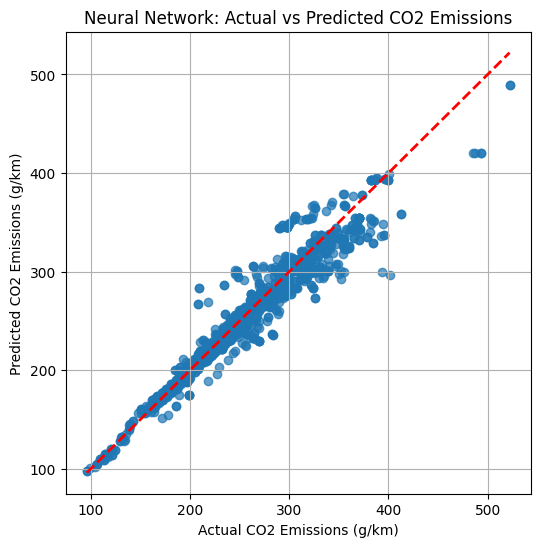

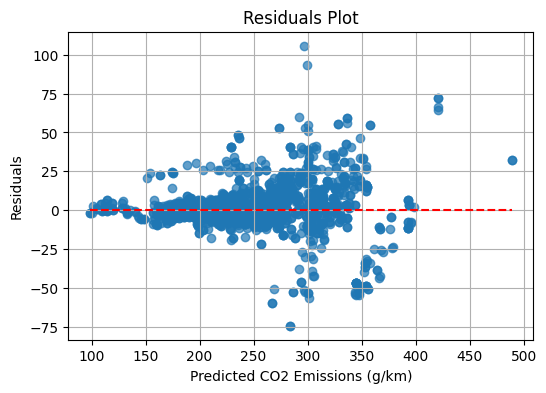

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn

# Load CO2 Emissions Canada dataset
df = pd.read_csv("CO2 Emissions_Canada.csv")

# Select numerical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[num_features].dropna()

# Separate features and target (CO2 Emissions)
y = X['CO2 Emissions(g/km)']
X = X.drop(columns=['CO2 Emissions(g/km)'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1,1)

# Split into train/test sets
train_size = int(0.75 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Define a simple neural network for regression
class CO2Net(nn.Module):
    def __init__(self, input_dim):
        super(CO2Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_scaled.shape[1]
model = CO2Net(input_dim)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 500

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(X_train)
    loss = criterion(y_pred_train, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}')

# Evaluate on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

mse = mean_squared_error(y_test.numpy(), y_pred_test.numpy())
r2 = r2_score(y_test.numpy(), y_pred_test.numpy())
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Visualization: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test.numpy(), y_pred_test.numpy(), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions (g/km)')
plt.ylabel('Predicted CO2 Emissions (g/km)')
plt.title('Neural Network: Actual vs Predicted CO2 Emissions')
plt.grid(True)
plt.show()

# Visualization: residuals
residuals = y_test.numpy() - y_pred_test.numpy()
plt.figure(figsize=(6,4))
plt.scatter(y_pred_test.numpy(), residuals, alpha=0.7)
plt.hlines(0, y_pred_test.min(), y_pred_test.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted CO2 Emissions (g/km)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()


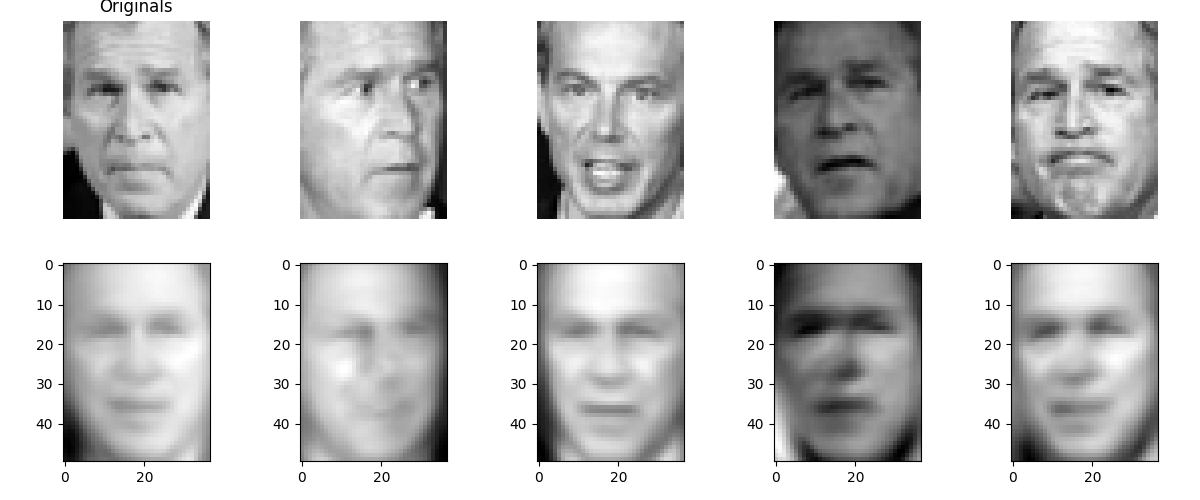

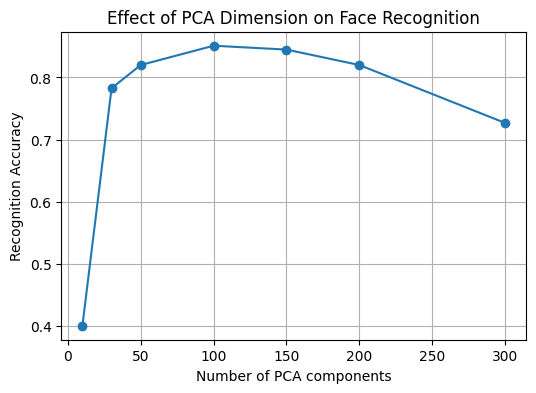

Animation saved as pca_faces.mp4 and pca_faces.gif and displayed inline.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Image
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Load dataset (Labeled Faces in the Wild)
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = faces.data  # flattened face images
y = faces.target

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Components to test
components_list = [10, 30, 50, 100, 150, 200, 300]
accuracies = []

# Prepare figure for animation
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
plt.tight_layout()

n_show = 5
orig_faces = X_test[:n_show].reshape((n_show, faces.images.shape[1], faces.images.shape[2]))

for i in range(n_show):
    axes[0, i].imshow(orig_faces[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Originals")

ims = []

# Function to run PCA and generate reconstructions
def run_pca(n_components):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Classifier
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    recon_faces = pca.inverse_transform(X_test_pca[:n_show])
    recon_faces = recon_faces.reshape((n_show, faces.images.shape[1], faces.images.shape[2]))

    ims_row = []
    for j in range(n_show):
        im = axes[1, j].imshow(recon_faces[j], cmap='gray', animated=True)
        ims_row.append(im)
    return ims_row, acc

frames = []
for n in components_list:
    ims_row, acc = run_pca(n)
    frames.append(ims_row)

# Create animation
ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True)

# Save as mp4 and gif
ani.save('pca_faces.mp4')
ani.save('pca_faces.gif', writer='imagemagick')

plt.close()

# Show GIF inline in Colab
with open("pca_faces.gif", "rb") as f:
    display(Image(data=f.read(), format='gif'))

# Plot recognition accuracy vs components
plt.figure(figsize=(6,4))
plt.plot(components_list, accuracies, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Recognition Accuracy")
plt.title("Effect of PCA Dimension on Face Recognition")
plt.grid(True)
plt.show()

print("Animation saved as pca_faces.mp4 and pca_faces.gif and displayed inline.")

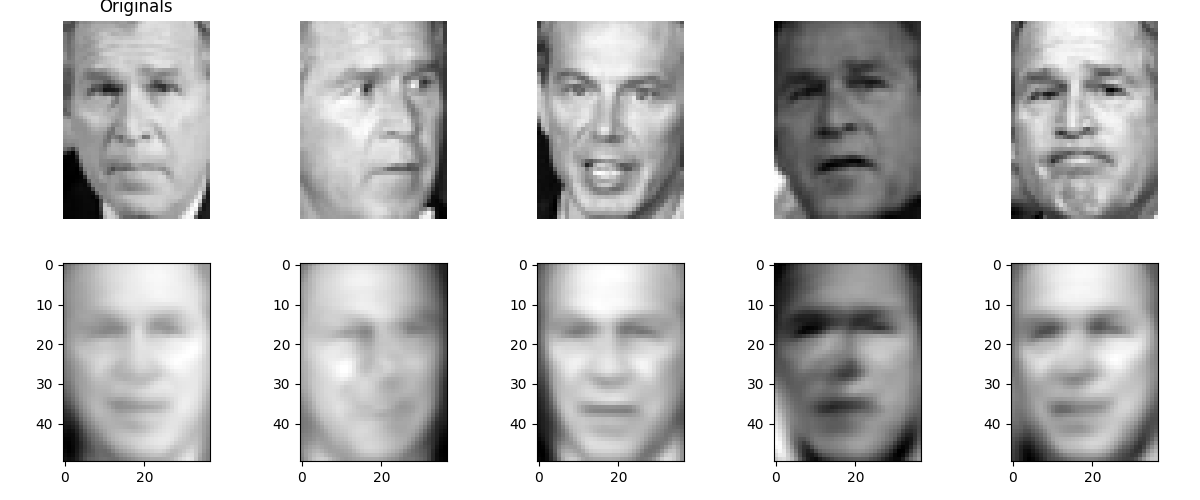

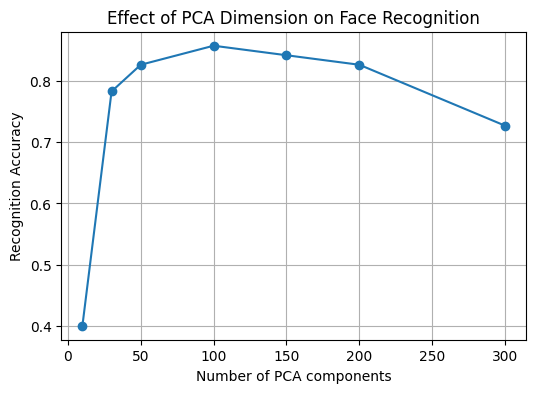

Animation saved as pca_faces.mp4 and pca_faces.gif and displayed inline.


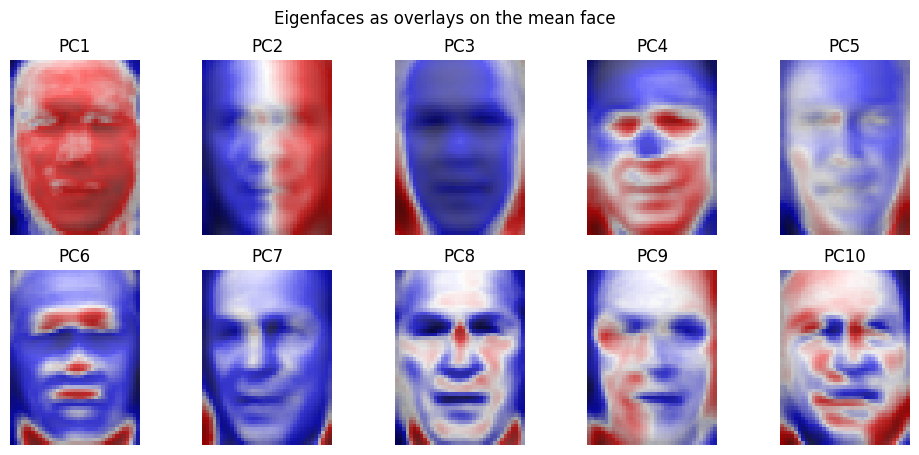

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, Image
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Load dataset (Labeled Faces in the Wild)
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = faces.data  # flattened face images
y = faces.target
h, w = faces.images.shape[1:]

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Components to test
components_list = [10, 30, 50, 100, 150, 200, 300]
accuracies = []

# Prepare figure for animation
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
plt.tight_layout()

n_show = 5
orig_faces = X_test[:n_show].reshape((n_show, h, w))

for i in range(n_show):
    axes[0, i].imshow(orig_faces[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Originals")

ims = []

# Function to run PCA and generate reconstructions
def run_pca(n_components):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Classifier
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    recon_faces = pca.inverse_transform(X_test_pca[:n_show])
    recon_faces = recon_faces.reshape((n_show, h, w))

    ims_row = []
    for j in range(n_show):
        im = axes[1, j].imshow(recon_faces[j], cmap='gray', animated=True)
        ims_row.append(im)
    return ims_row, acc, pca

frames = []
pca_models = []
for n in components_list:
    ims_row, acc, pca_model = run_pca(n)
    frames.append(ims_row)
    pca_models.append(pca_model)

# Create animation
ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True)

# Save as mp4 and gif
ani.save('pca_faces.mp4')
ani.save('pca_faces.gif', writer='imagemagick')

plt.close()

# Show GIF inline in Colab
with open("pca_faces.gif", "rb") as f:
    display(Image(data=f.read(), format='gif'))

# Plot recognition accuracy vs components
plt.figure(figsize=(6,4))
plt.plot(components_list, accuracies, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Recognition Accuracy")
plt.title("Effect of PCA Dimension on Face Recognition")
plt.grid(True)
plt.show()

print("Animation saved as pca_faces.mp4 and pca_faces.gif and displayed inline.")

# --- New: Visualize eigenfaces and how they relate to facial features ---
# Use the model with the largest number of components
best_pca = pca_models[-1]
mean_face = X_train.mean(axis=0).reshape(h, w)
eigenfaces = best_pca.components_.reshape((-1, h, w))

fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    if i < 10:
        ax.imshow(mean_face, cmap='gray')
        ax.imshow(eigenfaces[i], cmap='seismic', alpha=0.6)  # overlay PC on mean face
        ax.set_title(f"PC{i+1}")
        ax.axis('off')
plt.suptitle("Eigenfaces as overlays on the mean face")
plt.show()